In [2]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import math
import time

import valez_finite_VI_lib as vi
from data_set_lib import DataSet
import generic_optimization_lib as packing

In [3]:
#np.random.seed(12321)

alpha = 10 # IBP parameter
num_samples = 500 # Data set size
D = 2 # dimension
sigma_a = 3.0 ** 2
sigma_eps = 1.0 ** 2 # variance of noise
k_inf = 5 # take to be large for a good approximation to the IBP
pi, Z, mu, A, X = vi.generate_data(num_samples, D, k_inf, sigma_a, sigma_eps, alpha)
k_approx = k_inf

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(num_samples, D, k_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_a, sigma_eps)

data_set = DataSet(X, k_approx, alpha, sigma_eps, sigma_a)

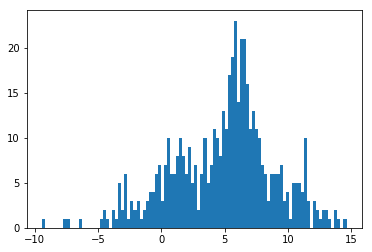

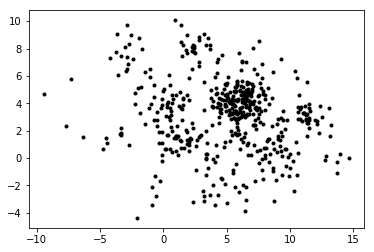

In [4]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [5]:
def truncate_nu(nu, nu_tol=1e-8):
    # CAVI can return nu values that are too close to 0 or 1 for the encoding.
    nu[nu < nu_tol] = nu_tol
    nu[nu > 1 - nu_tol] = 1 - nu_tol

def run_cavi_then_tr(data_set, param_init, maxiter=200, gtol=1e-6):
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_init)
    print('Running CAVI')
    tau, nu, phi_mu, phi_var = data_set.run_cavi(
            tau, nu, phi_mu, phi_var, max_iter=30, tol=1e-6)
    truncate_nu(nu)
    cavi_params = packing.pack_params(tau, phi_mu, phi_var, nu)
    print('Running TR')
    vb_opt = data_set.run_newton_tr(cavi_params, maxiter=maxiter, gtol=gtol)
    return vb_opt

In [6]:
data_set.trace.print_every = 10
subset_size = 50
num_subsets = int(math.ceil(num_samples / subset_size))
print num_subsets

10


In [10]:
params_list = []
data_subset_list = []

for subset in range(num_subsets):
    print('Subset %d of %d' % (subset, num_subsets))
    subset_slice = slice(subset * subset_size, (subset + 1) * subset_size)
    data_subset = DataSet(X[subset_slice, :], k_approx, alpha, sigma_eps, sigma_a)
    data_subset_list.append(data_subset)
    #params_init = packing.pack_params(
    #    tau_init, phi_mu_init, phi_var_init, )
    #vb_opt = run_cavi_then_tr(data_subset, params_init, maxiter=20, gtol=1e-2)
    tau, nu, phi_mu, phi_var = data_subset.run_cavi(
            deepcopy(tau_init), deepcopy(nu_init[subset_slice, :]),
            deepcopy(phi_mu_init), deepcopy(phi_var_init),
            max_iter=50, tol=1e-6)
    truncate_nu(nu)
    cavi_params = packing.pack_params(tau, phi_mu, phi_var, nu)
    params_list.append(cavi_params)


Subset 0 of 10
Step 0 objective: 47.7639276736
Step 10 objective: 0.192910956424
Step 20 objective: 0.617853689813
Step 30 objective: 0.144812837876
Step 40 objective: 0.00838269789969
Done with CAVI.
Subset 1 of 10
Step 0 objective: 46.7594039553
Step 10 objective: 0.224608757903
Step 20 objective: 0.0116021186087
Step 30 objective: 0.00166502153499
Step 40 objective: 0.000197451596314
Done with CAVI.
Subset 2 of 10
Step 0 objective: 47.3024726844
Step 10 objective: 0.183492329472
Step 20 objective: 0.121128200925
Step 30 objective: 0.218492938074
Step 40 objective: 0.0562942137192
Done with CAVI.
Subset 3 of 10
Step 0 objective: 48.8771755785
Step 10 objective: 1.08792509056
Step 20 objective: 0.132213398405
Step 30 objective: 0.0803594910257
Step 40 objective: 0.0227195995685
Done with CAVI.
Subset 4 of 10
Step 0 objective: 47.37291581
Step 10 objective: 0.258679779711
Step 20 objective: 0.201986785084
Step 30 objective: 0.0427371254021
Step 40 objective: 0.0791412653222
Done with C

In [11]:
n_test_samples = 500
plt.figure()
all_ll = []

for subset in range(num_subsets):
    params = params_list[subset]
    data_subset = data_subset_list[subset]
    tau, phi_mu, phi_var, nu = data_subset.unpack_params(params)
    phi_var_expanded = np.array([ phi_var for d in range(D)])
    z_sample, a_sample, pi_sample = vi.generate_parameter_draws(
        nu, phi_mu, phi_var_expanded, tau, n_test_samples)

    ll = [ vi.log_lik(data_subset.x, z_sample[n, :, :], a_sample[n, :, :], pi_sample[n, :],
                      sigma_eps, sigma_a, alpha, k_approx) for n in range(n_test_samples) ]

    all_ll.extend(ll)
    for k in range(k_approx):
        plt.plot(a_sample[:, 0, k], a_sample[:, 1, k], 'k.')

print(len(all_ll))
logsumexp_ll = sp.misc.logsumexp(all_ll)
plt.figure()
plt.hist(all_ll - logsumexp_ll, bins=50);



NameError: name 'tr_params_list' is not defined

In [10]:
import seaborn as sns

ImportError: No module named seaborn